#FGSM : 
* 구글 드라이브 preprocessed 완전 비우고 다시 코드 돌려서 저장하고 class 확인까지 해야할 것 같음 (중복되는 내용, 다른 dir로 섞여 들어간 거 혼합상태인듯)
* preprocessed 코드 수정 하고 이미지 만들면, 그거를 mount해서 사용하는 걸로 코드 수정해야할 것 같음 : 시간 너무 오래 걸림


## 해야할 것
* 동일한 사진의 원본과 adversarial 샘플 육안으로 비교하는 과정 필요 : 외형 차이 없음을 보여야 함. 육안으로 품질 비교
* 원래 기울기 값을 그대로 쓰는 것 VS FGSM 성능 비교
* CNN 적용한 adversarial example (CNN 역전파 있음, flatten 부분에 처리해서 하면?)
* CNN + RGB 적용한 adversarial example (R/G/B plane 각각 따로?)
* R, G, B 각각 gradient 계산해서 합치기?

FGSM TF 구현
- gradient tape 모든 레이어에 적용되는지
- CNN의 gradient 가져온 건지 확인하기


14, 17, 27, 33, 35

# 1. Data Mount & Import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as img
import keras
import os
from PIL import Image
import natsort
import io
import cv2

In [ ]:
cd drive/MyDrive/[한이음] 적대적 AI 공격에 대한 인공지능 보안기술 연구/3. 소스코드/GTSRB

/content/drive/.shortcut-targets-by-id/1WKEjdIyqtzI-NV5o0O_ixsHslngaSiQX/[한이음] 적대적 AI 공격에 대한 인공지능 보안기술 연구/3. 소스코드/GTSRB


# 2. Data Load & Preprocessing

In [ ]:
metainfo = pd.read_csv("Meta.csv")
traininfo = pd.read_csv("Train.csv")
testinfo = pd.read_csv("Test.csv")

In [ ]:
# 43개 클래스 모두 사용
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

Image Shape: (54, 53, 3)


Text(0.5, 1.0, 'imgRGB')

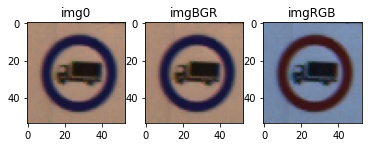

In [ ]:
## 일단 이미지 하나만 읽어보기
img0 = cv2.imread("Test/00000.png")
print("Image Shape:", img0.shape) # (54, 53, 3)
plt.subplot(131)
plt.imshow(img0)
plt.title('img0')

# OpenCV : B-G-R, matplotlib : R-G-B => BGR을 RGB로 바꿔줘야 사진이 제대로 표시됨
imgBGR = img0
imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)

plt.subplot(132)
plt.imshow(imgBGR)
plt.title('imgBGR')

plt.subplot(133)
plt.imshow(imgRGB)
plt.title('imgRGB')

In [ ]:
## R/G/B plane 각각 plot 확인
imgR = imgRGB[:,:,0]
imgG = imgRGB[:,:,1]
imgB = imgRGB[:,:,2]

## RGB 재합성
imgRGBn = np.dstack((imgR,imgG,imgB))
imgRBGn = np.dstack((imgR,imgB,imgG))
imgGRBn = np.dstack((imgG,imgR,imgB))
imgGBRn = np.dstack((imgG,imgB,imgR))
imgBRGn = np.dstack((imgB,imgR,imgG))
imgBGRn = np.dstack((imgB,imgG,imgR))

## plot으로 확인
# R/G/B 각각
plt.subplot(331);plt.imshow(imgR);plt.title('imgR')
plt.subplot(332);plt.imshow(imgG);plt.title('imgG')
plt.subplot(333);plt.imshow(imgB);plt.title('imgB')
# RGB 재합성
plt.subplot(334);plt.imshow(imgRGBn);plt.title('imgRGBn')
plt.subplot(335);plt.imshow(imgRBGn);plt.title('imgRBGn')
plt.subplot(336);plt.imshow(imgGRBn);plt.title('imgGRBn')
plt.subplot(337);plt.imshow(imgGBRn);plt.title('imgGBRn')
plt.subplot(338);plt.imshow(imgBRGn);plt.title('imgBRGn')
plt.subplot(339);plt.imshow(imgBGRn);plt.title('imgBGRn')

In [ ]:
### PREPROCESSING : 128by128 데이터셋
y_meta = list(range(43))
y_train = traininfo.ClassId
y_test = testinfo.ClassId
X_meta = np.zeros([64,64,3,len(y_meta)])
X_train = np.zeros([64,64,3,len(y_train)])
X_test = np.zeros([64,64,3,len(y_test)])

datanames = ["Meta", "Test"] # Train은 따로 작성

for dataname in datanames:
  filenames = natsort.natsorted(os.listdir(dataname))

  # (1)1:1cut (2)64by64resize (3)dataset (4)드라이브저장
  for i in range(len(filenames)):
    filepath = dataname + "/" + filenames[i]
    imgBGR = cv2.imread(filepath)
    imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB) # 원본 RGB 이미지
  
    # (1)1:1cut
    imgsize = imgRGB.shape
    imgsquare = imgRGB
    if (imgsize[0] == imgsize[1]): # 이미 1:1이라면 그대로 사용
      pass 
    elif (imgsize[0] != imgsize[1]): # 1:1로 잘라서 사용 (가운데에 맞춰 자름)
      lendif = imgsize[0] - imgsize[1] # 가로세로 길이 차이
      if (lendif < 0): # 가로가 긴 이미지 : 세로 기준
        midcut1 = abs(lendif)//2 # 몫
        imgsquare = imgRGB[:,midcut1:midcut1+imgsize[0]]
        # # 어떤 이미지가 cut 되었는지 확인
        # print(f"{i} 가로 cut : {imgsize} -> {imgsquare.shape}")
      elif (lendif > 0): # 세로가 긴 이미지 : 가로 기준
        midcut2 = abs(lendif)//2 # 몫
        imgsquare = imgRGB[midcut2:midcut2+imgsize[1],:]
        # # 어떤 이미지가 cut 되었는지 확인
        # print(f"{i} 세로 cut : {imgsize} -> {imgsquare.shape}")

    # (2)64by64resize
    resrat = 64/imgsquare.shape[0]
    imgresize = cv2.resize(imgsquare, dsize=(0,0), fx=resrat, fy=resrat, interpolation=cv2.INTER_LINEAR)

    # (3)dataset
    if dataname == "Meta":
      X_meta[:,:,:,i] = imgresize
    elif dataname == "Test":
      X_test[:,:,:,i] = imgresize

    # (4)드라이브저장
    fname = "./" + dataname + "_preprocessed/" + str(i) + ".png"
    imgcv2 = imgresize[:,:,::-1] # cv2 BGR 순서 맞추기
    cv2.imwrite(fname, imgcv2)

# X_train =====================================================================#
dirnames = natsort.natsorted(os.listdir("Train"))

totfnum = 0
for dirname in dirnames:
  fpath = "./Train/" + dirname

  filenames = natsort.natsorted(os.listdir(fpath))

  # (1)1:1cut (2)64by64resize (3)dataset (4)드라이브저장
  for i in range(len(filenames)):
    filepath = "Train/" + dirname + "/" + filenames[i]
    imgBGR = cv2.imread(filepath)
    imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB) # 원본 RGB 이미지
  
    # (1)1:1cut
    imgsize = imgRGB.shape
    imgsquare = imgRGB
    if (imgsize[0] == imgsize[1]): # 이미 1:1이라면 그대로 사용
      pass 
    elif (imgsize[0] != imgsize[1]): # 1:1로 잘라서 사용 (가운데에 맞춰 자름)
      lendif = imgsize[0] - imgsize[1] # 가로세로 길이 차이
      if (lendif < 0): # 가로가 긴 이미지 : 세로 기준
        midcut1 = abs(lendif)//2 # 몫
        imgsquare = imgRGB[:,midcut1:midcut1+imgsize[0]]
        # # 어떤 이미지가 cut 되었는지 확인
        # print(f"{i} 가로 cut : {imgsize} -> {imgsquare.shape}")
      elif (lendif > 0): # 세로가 긴 이미지 : 가로 기준
        midcut2 = abs(lendif)//2 # 몫
        imgsquare = imgRGB[midcut2:midcut2+imgsize[1],:]
        # # 어떤 이미지가 cut 되었는지 확인
        # print(f"{i} 세로 cut : {imgsize} -> {imgsquare.shape}")

    # (2)64by64resize
    resrat = 64/imgsquare.shape[0]
    imgresize = cv2.resize(imgsquare, dsize=(0,0), fx=resrat, fy=resrat, interpolation=cv2.INTER_LINEAR)

    # (3)dataset
    X_train[:,:,:,totfnum] = imgresize
    totfnum += 1

    # (4)드라이브저장
    fname = "./Train_preprocessed/" + dirname + "_" + str(i) + ".png"
    imgcv2 = imgresize[:,:,::-1] # cv2 BGR 순서 맞추기
    cv2.imwrite(fname, imgcv2)

    print(dirname, ":", i)

In [ ]:
# RGB 하나씩 확인하면 제대로 된거 확인 가능한데, 그냥 RGB 한꺼번에 출력하면 이상하게 나옴 : 이유를 모르겠음...
testimg1 = X_meta[:,:,:,1]
print(testimg1.shape)
plt.subplot(151)
plt.imshow(testimg1[:,:,1])

testimg2 = X_meta[:,:,:,3]
plt.subplot(152)
plt.imshow(testimg2)

testimg3 = X_meta[:,:,:,13]
plt.subplot(153)
plt.imshow(testimg3)

testimg4 = X_meta[:,:,:,25]
plt.subplot(154)
plt.imshow(testimg4)

testimg5 = X_meta[:,:,:,30]
plt.subplot(155)
plt.imshow(testimg5[:,:,:])

# 3. FGSM

In [ ]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

# pretrained model 없어서 일단은 안쓰고...

# train 이미지 너무 오래걸려서 못 썼고, test 이미지로 해본

In [ ]:
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = image/255
  image = tf.image.resize(image, (224,224))
  # image = image([None, ...]) # 왜 에러나는지?
  return image

In [ ]:
image = preprocess(X_test[:,:,:,32])

In [ ]:
plt.figure
plt.imshow(image)

In [ ]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
#     prediction = pretrained_model(input_image) 훈련을 시켜야 함...
    loss = loss_object(input_label, prediction)

  gradient = tape.gradient(loss, input_image)
  signed_grad = tf.sign(gradient)
  return signed_grad